In [1]:
!curl -L -o noahs_utils.py https://gist.github.com/bantucaravan/1956003e25c056c550a088542b41dc91/raw/noahs_utility_funcs.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11663  100 11663    0     0  36427      0 --:--:-- --:--:-- --:--:-- 36427


In [1]:
import os
import glob
import re
import datetime as dt
from collections import defaultdict
import sys
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

#import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from tensorflow.keras.callbacks import ModelCheckpoint#, TensorBoard
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing import image

from noahs_utils import *
from proj_utils import *

### View Log Table

In [2]:
logpath = '../logs/model_log.json'
log = read_log_df(path=logpath)
log.shape

/Users/noah.chasek-macfoy@ibm.com/Desktop/projects/Drone proj/code/noahs_utils.py:318: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(list(dct.values()))


(48, 258)

Note: model's whose names are time stamps, are "warm-started" models which continued training from a previously trained configuration.  
Note: see build_models.py for the exact model configuration.

In [25]:
cols = ['run_id', 'metrics_report.weighted avg.recall', 'EPOCH', 'MODEL', 'OPT']
allcols(log.sort_values('metrics_report.accuracy.support', ascending=False).loc[:, cols].head(20))

,run_id,metrics_report.weighted avg.recall,EPOCH,MODEL,OPT
2020-02-09_21h53m57s,2020-02-09_21h53m57s,0.859756,70.0,VGG16 Fine-tuning,opt-adam-lr1e-05
2020-02-09_14h25m27s,2020-02-09_14h25m27s,0.841463,40.0,2020-02-07_01h10m05s,NaN
2020-02-09_14h07m18s,2020-02-09_14h07m18s,0.814024,40.0,2020-02-07_01h36m15s,NaN
2020-02-09_15h50m36s,2020-02-09_15h50m36s,0.807927,70.0,2020-02-08_23h29m06s,opt-adam
2020-02-09_04h52m57s,2020-02-09_04h52m57s,0.786585,100.0,VGG16 Model,NaN
2020-02-09_17h27m39s,2020-02-09_17h27m39s,0.777439,40.0,2020-02-09_07h23m26s,opt-adam
2020-02-09_07h23m26s,2020-02-09_07h23m26s,0.777439,100.0,Inception-ResNet V2 finetuning final-module,NaN
2020-02-07_01h36m15s,2020-02-07_01h36m15s,0.774390,NaN,Lite Test,NaN
2020-02-07_01h10m05s,2020-02-07_01h10m05s,0.768293,NaN,Lite Test,NaN
2020-02-09_12h22m07s,2020-02-09_12h22m07s,0.746951,70.0,Inception-ResNet V2 w. Dropout Model,NaN


In [26]:
# cols = ['metrics_report.weighted avg.recall', 'EPOCH', 'MODEL', 'run_id']
# log.sort_values('metrics_report.accuracy.support', ascending=False).loc[:, cols].head(10).to_html('../misc/Top 10 models Log.html', index=False)

### View Single Example

In [20]:
run_id = '2020-02-07_01h10m05s' # '2020-02-09_04h52m57s' # 
example = read_log_json(path=logpath, run_num=run_id)
print('Name:', example['MODEL'])
print('Epochs:', example.get('EPOCH'))
print('Optimizer Alg:', example.get('OPT'))
print('Acc:', example['metrics_report']['weighted avg']['recall'])

Name: Lite Test
Epochs: None
Optimizer Alg: None
Acc: 0.7682926829268293


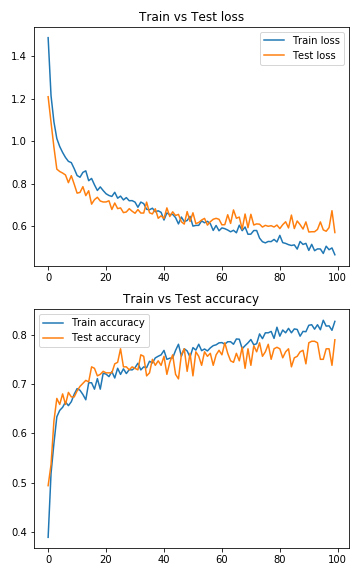

In [28]:
imgpath = '../figs/Train Test %s %s.png' %('accuracy', run_id)
from IPython.display import Image
Image(filename=imgpath) 

### Reconstruct Data Gen and Load Saved Model

In [83]:
# reconstruct validation generator. 
new_gen = reconstruct_img_gen(example, subset='val')

("flow_from_directory() got an unexpected keyword argument 'image_data_generator'",)
("flow_from_directory() got an unexpected keyword argument 'data_format'",)
("flow_from_directory() got an unexpected keyword argument 'image_shape'",)
("flow_from_directory() got an unexpected keyword argument 'split'",)
("flow_from_directory() got an unexpected keyword argument 'dtype'",)
("flow_from_directory() got an unexpected keyword argument 'samples'",)
("flow_from_directory() got an unexpected keyword argument 'num_classes'",)
("flow_from_directory() got an unexpected keyword argument 'class_indices'",)
("flow_from_directory() got an unexpected keyword argument 'n'",)
("flow_from_directory() got an unexpected keyword argument 'batch_index'",)
("flow_from_directory() got an unexpected keyword argument 'total_batches_seen'",)
("flow_from_directory() got an unexpected keyword argument 'lock'",)
("flow_from_directory() got an unexpected keyword argument 'index_generator'",)
Found 328 images belong

In [35]:
# load saved model
#modelpath = '../saved models/model_2020-02-06_06:21:38.h5'
modelpath = example['bestmodelpath']
model = load_model(modelpath)

In [36]:
proba_preds = model.predict(new_gen, steps=len(new_gen))
preds = np.argmax(proba_preds, axis=1)
ytrue = new_gen.classes[new_gen.index_array]

In [37]:
out = metrics_report(ytrue, preds, classnames=new_gen.class_indices.keys())
out

,cardboard,glass,metal,paper,plastic,trash,accuracy,macro avg,weighted avg
precision,0.803922,0.750000,0.893617,0.870130,0.724638,0.437500,0.786585,0.746634,0.791567
recall,0.891304,0.784615,0.750000,0.807229,0.819672,0.411765,0.786585,0.744098,0.786585
f1-score,0.845361,0.766917,0.815534,0.837500,0.769231,0.424242,0.786585,0.743131,0.786749
support,46.000000,65.000000,56.000000,83.000000,61.000000,17.000000,0.786585,328.000000,328.000000


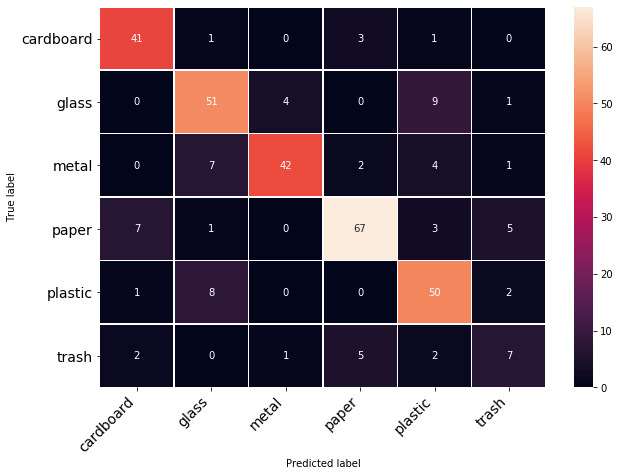

In [38]:
cm = confusion_matrix(ytrue, preds, class_names=new_gen.class_indices.keys())

In [68]:
class history:
    history= log['model_history']
    epoch = list(range(len(log['model_history']['loss'])))
top_epochs(history)
dict(zip(history.epoch, log['model_history']['val_accuracy']))

Best accuracy by epoch (1-indexed):


{0: 0.49390244483947754,
 1: 0.5365853905677795,
 2: 0.625,
 3: 0.6707317233085632,
 4: 0.6585366129875183,
 5: 0.6798780560493469,
 6: 0.6585366129875183,
 7: 0.6829268336296082,
 8: 0.6737805008888245,
 9: 0.6737805008888245,
 10: 0.6859756112098694,
 11: 0.6951219439506531,
 12: 0.7012194991111755,
 13: 0.707317054271698,
 14: 0.7042682766914368,
 15: 0.7347561120986938,
 16: 0.7317073345184326,
 17: 0.7164633870124817,
 18: 0.7195122241973877,
 19: 0.7256097793579102,
 20: 0.7225610017776489,
 21: 0.7225610017776489,
 22: 0.7225610017776489,
 23: 0.7408536672592163,
 24: 0.7439024448394775,
 25: 0.7713414430618286,
 26: 0.7347561120986938,
 27: 0.7347561120986938,
 28: 0.7286585569381714,
 29: 0.7347561120986938,
 30: 0.7317073345184326,
 31: 0.7286585569381714,
 32: 0.7591463327407837,
 33: 0.7560975551605225,
 34: 0.7164633870124817,
 35: 0.7225610017776489,
 36: 0.75,
 37: 0.7378048896789551,
 38: 0.7469512224197388,
 39: 0.7378048896789551,
 40: 0.7560975551605225,
 41: 0.71951

In [62]:
history.history

({'loss': [1.4887528726957502,
   1.215335532550898,
   1.0919897313571083,
   1.013389967145963,
   0.9758446853085341,
   0.9478128247670998,
   0.9241044143745802,
   0.9059765290350935,
   0.9000091935714446,
   0.871451758016828,
   0.8393075131722705,
   0.8310973714379704,
   0.8540472288476936,
   0.8613184507076557,
   0.8148580144972822,
   0.8254172912550188,
   0.795314677700198,
   0.7687445657825038,
   0.785550498315112,
   0.768407427887032,
   0.7533135522005245,
   0.74523024874575,
   0.740608948657955,
   0.7602200970660508,
   0.7323456635841956,
   0.7423048984950484,
   0.7241734975603371,
   0.7351575480327347,
   0.7203436674575461,
   0.7209866168272442,
   0.7138732324493416,
   0.6896969031424544,
   0.7140835522256825,
   0.706819380570321,
   0.6799776041669543,
   0.6780918746242696,
   0.6851666834019967,
   0.6685015054849478,
   0.6729907338166129,
   0.6657225087757024,
   0.6294813850616438,
   0.6630191949967346,
   0.6548657753079186,
   0.65638294

In [67]:
# Check if new_gen.classes[new_gen.index_array] is accurate

#proba_preds=[]
preds=[]
ytrue=[]
for i in range(len(new_gen)):
    (x, y) = new_gen[i] # batch
    proba_preds = model.predict(x)
    preds.extend(np.argmax(proba_preds, axis=1).tolist())
    ytrue.extend(np.argmax(y,axis=1).tolist())
    